In [1]:
# this one use 200 brackets as input.
# after smoothing, we do resample to 50 brackets.

In [2]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.insert(0, '../scripts/')

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 196

In [4]:
%load_ext autoreload
%autoreload 1

In [107]:
%aimport shapeslib
%aimport etllib
%aimport smoothlib
%aimport update_source
%aimport constants

# Methodology overview

See this [doc](https://docs.google.com/document/d/1-ro2bg-VSg-i-SxCW4_UadS2HPFAbFjc3PwBww134xY/edit)

# Step1: load all source files

The source files downloaded from povcal have following format (check the [doc](https://pip.worldbank.org/api) for more detail):

In [6]:
s000 = pd.read_csv('../source/income_mountain/0000.csv')
s000.head()

,region_name,region_code,country_name,country_code,reporting_year,reporting_level,survey_acronym,survey_coverage,survey_year,welfare_type,...,decile9,decile10,cpi,ppp,reporting_pop,reporting_gdp,reporting_pce,is_interpolated,distribution_type,estimation_type
0,Sub-Saharan Africa,SSA,Angola,AGO,1981,national,NaN,NaN,NaN,consumption,...,0.158687,0.402455,NaN,80.931801,8640478.0,3276.361709,NaN,True,micro,extrapolation
1,Sub-Saharan Africa,SSA,Angola,AGO,1982,national,NaN,NaN,NaN,consumption,...,0.158687,0.402455,NaN,80.931801,8952971.0,3162.004129,NaN,True,micro,extrapolation
2,Sub-Saharan Africa,SSA,Angola,AGO,1983,national,NaN,NaN,NaN,consumption,...,0.158687,0.402455,NaN,80.931801,9278104.0,3179.348236,NaN,True,micro,extrapolation
3,Sub-Saharan Africa,SSA,Angola,AGO,1984,national,NaN,NaN,NaN,consumption,...,0.158687,0.402455,NaN,80.931801,9614756.0,3252.107869,NaN,True,micro,extrapolation
4,Sub-Saharan Africa,SSA,Angola,AGO,1985,national,NaN,NaN,NaN,consumption,...,0.158687,0.402455,NaN,80.931801,9961993.0,3248.608116,NaN,True,micro,extrapolation


In [7]:
s000.columns

Index(['region_name', 'region_code', 'country_name', 'country_code',
       'reporting_year', 'reporting_level', 'survey_acronym',
       'survey_coverage', 'survey_year', 'welfare_type',
       'survey_comparability', 'comparable_spell', 'poverty_line', 'headcount',
       'poverty_gap', 'poverty_severity', 'watts', 'mean', 'median', 'mld',
       'gini', 'polarization', 'decile1', 'decile2', 'decile3', 'decile4',
       'decile5', 'decile6', 'decile7', 'decile8', 'decile9', 'decile10',
       'cpi', 'ppp', 'reporting_pop', 'reporting_gdp', 'reporting_pce',
       'is_interpolated', 'distribution_type', 'estimation_type'],
      dtype='object')

In [8]:
s000.welfare_type.unique()

array(['consumption', 'income'], dtype=object)

In [9]:
s000.reporting_level.unique()

array(['national', 'urban', 'rural'], dtype=object)

there are 201 csv files downloaded, where the file number 0000-0200 means a poverty line defined as following: 

In [10]:
all_brackets = np.logspace(-7, 13, 201, endpoint=True, base=2)
brackets_delta = 0.1  # it's (13 - (-7)) / 200

In [11]:
all_brackets[0]

0.0078125

In [12]:
s000['poverty_line'].unique()

array([0.0078125])

In [13]:
all_brackets[200]

8192.0

In [14]:
len(all_brackets)

201

In [15]:
def step1():
    res = dict()
    for f in os.listdir('../source/income_mountain'):
        if f.endswith('.csv'):
            fn = f.split('.')[0]
            bracket = fn.lstrip('0')
            if bracket == '':
                bracket = 0
            else:
                bracket = int(bracket)
            res[bracket] = etllib.load_file_preprocess(os.path.join('../source/income_mountain', f))
    return res

In [16]:
res1 = step1()

In [17]:
# re-download some files containing duplicates if necessary
# redo = [44, 46, 85, 100, 116, 118, 126, 166, 199]

In [18]:
# for i in redo:
#     update_source.process(i, resume=False)

In [19]:
len(res1.keys())

201

In [20]:
res1[0]

country_name  headcount      mean  reporting_pop
country year reporting_level                                                 
AGO     1981 national              Angola        0.0  5.470636      8640478.0
        1982 national              Angola        0.0  5.279690      8952971.0
        1983 national              Angola        0.0  5.308650      9278104.0
        1984 national              Angola        0.0  5.430139      9614756.0
        1985 national              Angola        0.0  5.424295      9961993.0
...                                   ...        ...       ...            ...
ZWE     2015 national            Zimbabwe        0.0  4.421709     13814642.0
        2016 national            Zimbabwe        0.0  4.091198     14030338.0
        2017 national            Zimbabwe        0.0  3.916933     14236599.0
        2018 national            Zimbabwe        0.0  4.184416     14438812.0
        2019 national            Zimbabwe        0.0  3.997762     14645473.0

[6682 rows x 4 columns]

# step 2: create CDF for each data point

In [21]:
# first see if all dataframes in res1 has same shape
shape = res1[0].shape

for i, df in res1.items():
    if df.shape != shape:
        print('{i}th has different shape')
        break
else:
    print('all dataframe have same shape!')

all dataframe have same shape!


In [22]:
# insert a new index level, merge all dataframes
def step2(res1):
    res = list()
    for i, df in res1.items():
        df_new = df.copy()
        df_new['i'] = i
        df_new = df_new.set_index('i', append=True)['headcount']
        res.append(df_new)
    return pd.concat(res).sort_index()

In [23]:
res2 = step2(res1)

In [24]:
res2 

country  year  reporting_level  i  
AGO      1981  national         0      0.0
                                1      0.0
                                2      0.0
                                3      0.0
                                4      0.0
                                      ... 
ZWE      2019  national         196    1.0
                                197    1.0
                                198    1.0
                                199    1.0
                                200    1.0
Name: headcount, Length: 1343082, dtype: float64

In [25]:
# double check shape
shape[0] * 201 == res2.shape[0]

True

In [26]:
res2.reset_index().reporting_level.unique()

array(['national', 'urban', 'rural'], dtype=object)

<AxesSubplot:xlabel='i'>

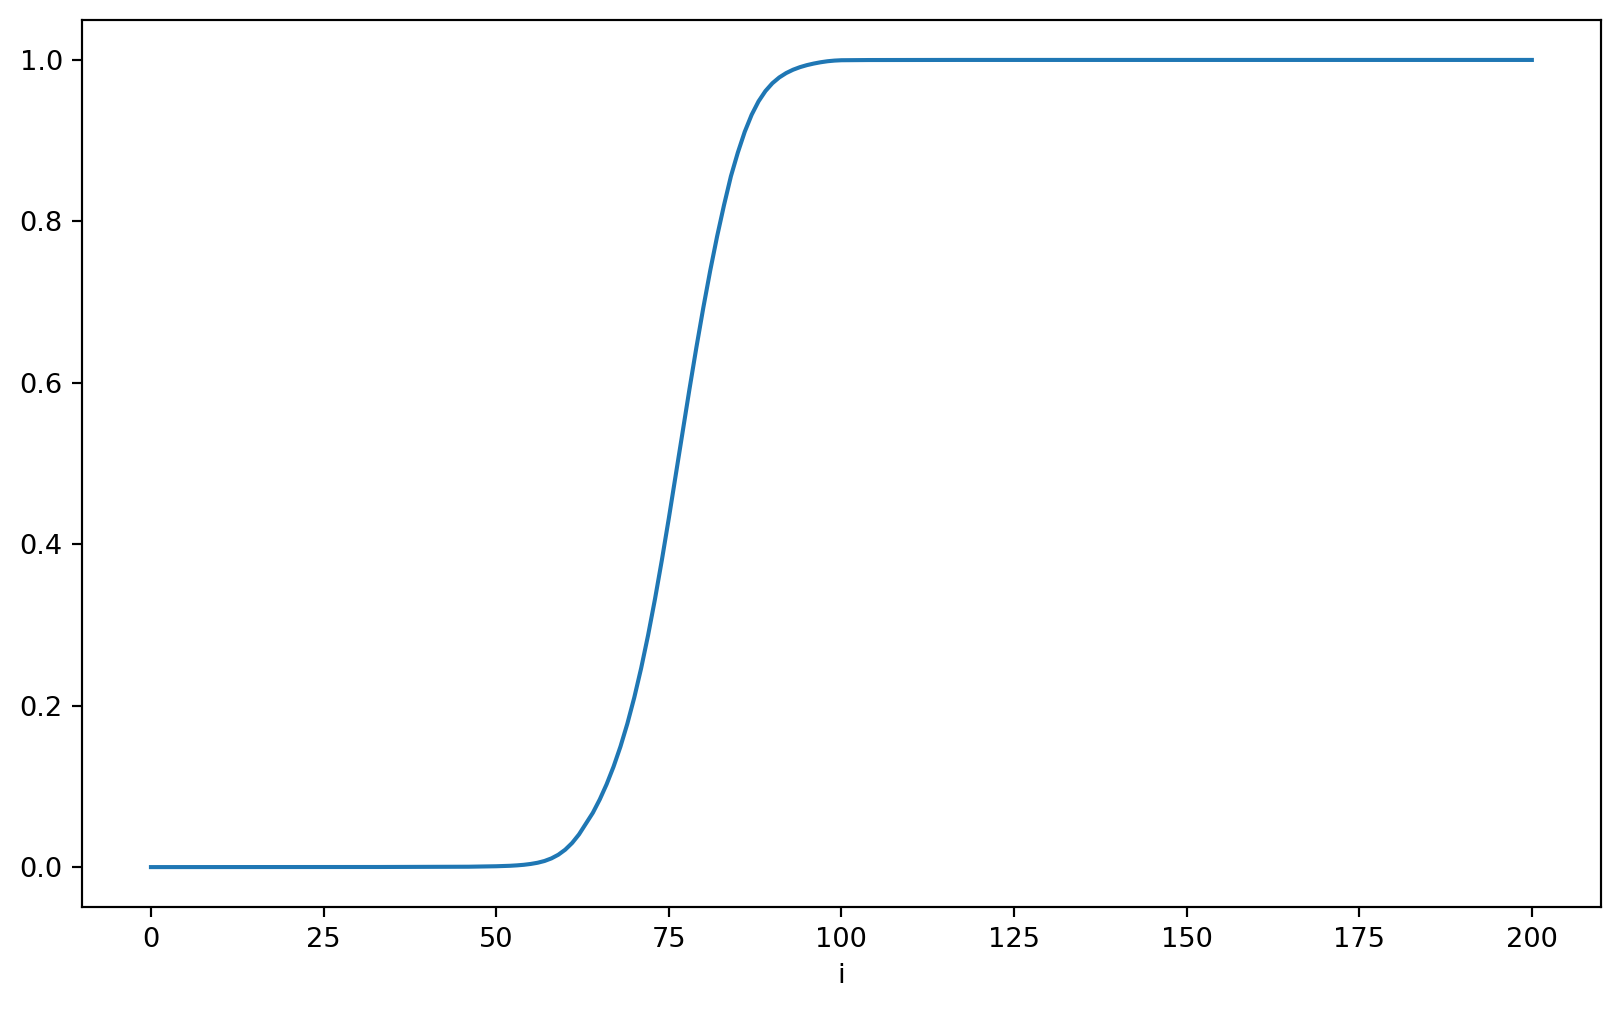

In [27]:
res2.loc['CHN', 1986, 'national'].plot()

# step 3: check NaNs

Sometimes the API will return NaNs for some countries. We will interpolate if there are NaNs

In [28]:
res2[pd.isnull(res2)]

country  year  reporting_level  i  
GNB      1981  national         93    NaN
                                94    NaN
                                95    NaN
                                96    NaN
                                97    NaN
                                       ..
SLV      1990  national         196   NaN
                                197   NaN
                                198   NaN
                                199   NaN
                                200   NaN
Name: headcount, Length: 3465, dtype: float64

In [29]:
res2[pd.isnull(res2)].reset_index()[['country', 'year', 'reporting_level']].drop_duplicates()

,country,year,reporting_level
0,GNB,1981,national
108,GNB,1982,national
216,GNB,1983,national
325,GNB,1984,national
433,GNB,1985,national
540,GNB,1986,national
648,GNB,1987,national
756,GNB,1988,national
863,GNB,1989,national
970,GNB,1990,national


In [30]:
# see what it looks like
res2.loc['SLV', 1990, 'national'].dropna()

i
0      0.030277
1      0.030318
2      0.030318
3      0.030379
4      0.030379
         ...   
151    0.999795
152    0.999795
153    0.999795
154    0.999795
155    0.999814
Name: headcount, Length: 156, dtype: float64

In [31]:
for i in res2[pd.isnull(res2)].reset_index()[['country', 'year', 'reporting_level']].drop_duplicates().values:
    s = res2.loc[tuple(i)]
    print(tuple(i), end=',')
    idx = s[pd.isnull(s)].index
    print(idx.values[0])

('GNB', 1981, 'national'),93
('GNB', 1982, 'national'),93
('GNB', 1983, 'national'),92
('GNB', 1984, 'national'),93
('GNB', 1985, 'national'),94
('GNB', 1986, 'national'),93
('GNB', 1987, 'national'),93
('GNB', 1988, 'national'),94
('GNB', 1989, 'national'),94
('GNB', 1990, 'national'),95
('GNB', 1991, 'national'),95
('GNB', 1992, 'national'),92
('SLE', 1981, 'national'),131
('SLE', 1982, 'national'),131
('SLE', 1983, 'national'),131
('SLE', 1984, 'national'),131
('SLE', 1985, 'national'),130
('SLE', 1986, 'national'),129
('SLE', 1987, 'national'),130
('SLE', 1988, 'national'),129
('SLE', 1989, 'national'),128
('SLE', 1990, 'national'),129
('SLE', 1991, 'national'),129
('SLE', 1992, 'national'),126
('SLE', 1993, 'national'),126
('SLE', 1994, 'national'),126
('SLE', 1995, 'national'),125
('SLE', 1996, 'national'),125
('SLE', 1997, 'national'),124
('SLE', 1998, 'national'),124
('SLE', 1999, 'national'),123
('SLE', 2000, 'national'),124
('SLE', 2001, 'national'),122
('SLE', 2002, 'nationa

In [32]:
# so the missing values are for the tails. 
# to do interpolation, first we check the available data, to find the first series that doesn't include missing values.
# and check where the value 1. 
_missings = res2[pd.isnull(res2)].reset_index()[['country', 'year', 'reporting_level']].drop_duplicates()
first_without_na = _missings.groupby(['country', 'reporting_level']).max()['year'] + 1

In [33]:
first_without_na.to_dict()

{('GNB', 'national'): 1993,
 ('SLE', 'national'): 2004,
 ('SLV', 'national'): 1991}

In [34]:
def where_is_one(x):
    return x[x == 1].index[0]

In [35]:
def get_fillna_from(k, v):
    idx = (k[0], v, k[1])
    return where_is_one(res2[idx])

fillna_from = dict([(k, get_fillna_from(k, v)) for k, v in first_without_na.to_dict().items()])

In [36]:
fillna_from

{('GNB', 'national'): 135, ('SLE', 'national'): 119, ('SLV', 'national'): 158}

In [37]:
# interpolate
def _run(ser, fill_from=-1):
    if ser.hasnans:
        ser = ser.droplevel([0, 1, 2])
        ser.iloc[fill_from:] = 1
        ser = ser.interpolate(method='cubic', order=2)
        ser[ser>1] = 1
        return ser
    return ser.droplevel([0, 1, 2])


def step3(res2):
    res = []
    gs = res2.groupby(['country', 'year', 'reporting_level'])
    for g, df in gs:
        idx = df.index
        if (g[0], g[2]) in fillna_from:
            # print('fillna: ', g)
            fill_from = fillna_from[g[0], g[2]]
            df_new = _run(df, fill_from)
        else:
            df_new = _run(df)
        df_new.index = idx
        res.append(df_new)
    return pd.concat(res)
    

In [38]:
res3 = step3(res2)

In [39]:
res3 

country  year  reporting_level  i  
AGO      1981  national         0      0.0
                                1      0.0
                                2      0.0
                                3      0.0
                                4      0.0
                                      ... 
ZWE      2019  national         196    1.0
                                197    1.0
                                198    1.0
                                199    1.0
                                200    1.0
Name: headcount, Length: 1343082, dtype: float64

In [40]:
assert res3.max() == 1, "maximum should be 1, possiblly the interpolation is not working"

In [41]:
res3.loc[res3.index.duplicated()]

Series([], Name: headcount, dtype: float64)

<AxesSubplot:xlabel='i'>

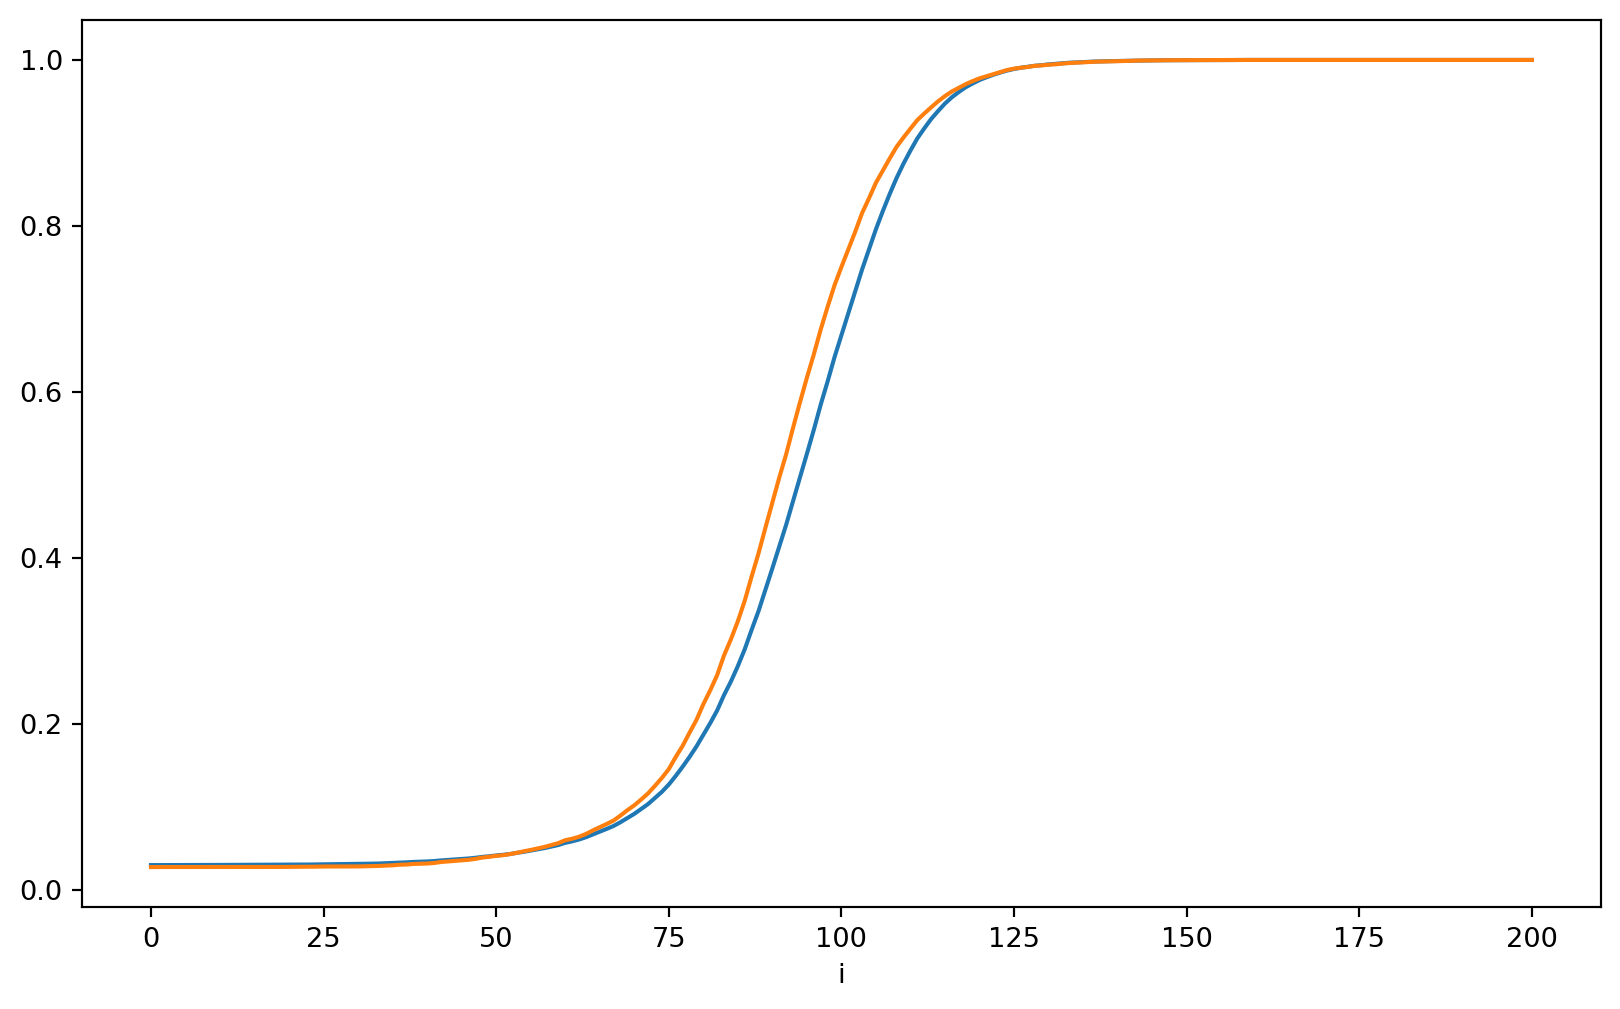

In [42]:
res3.loc[('SLV', 1990, 'national')].plot()
res3.loc[('SLV', 1991, 'national')].plot()

<AxesSubplot:xlabel='i'>

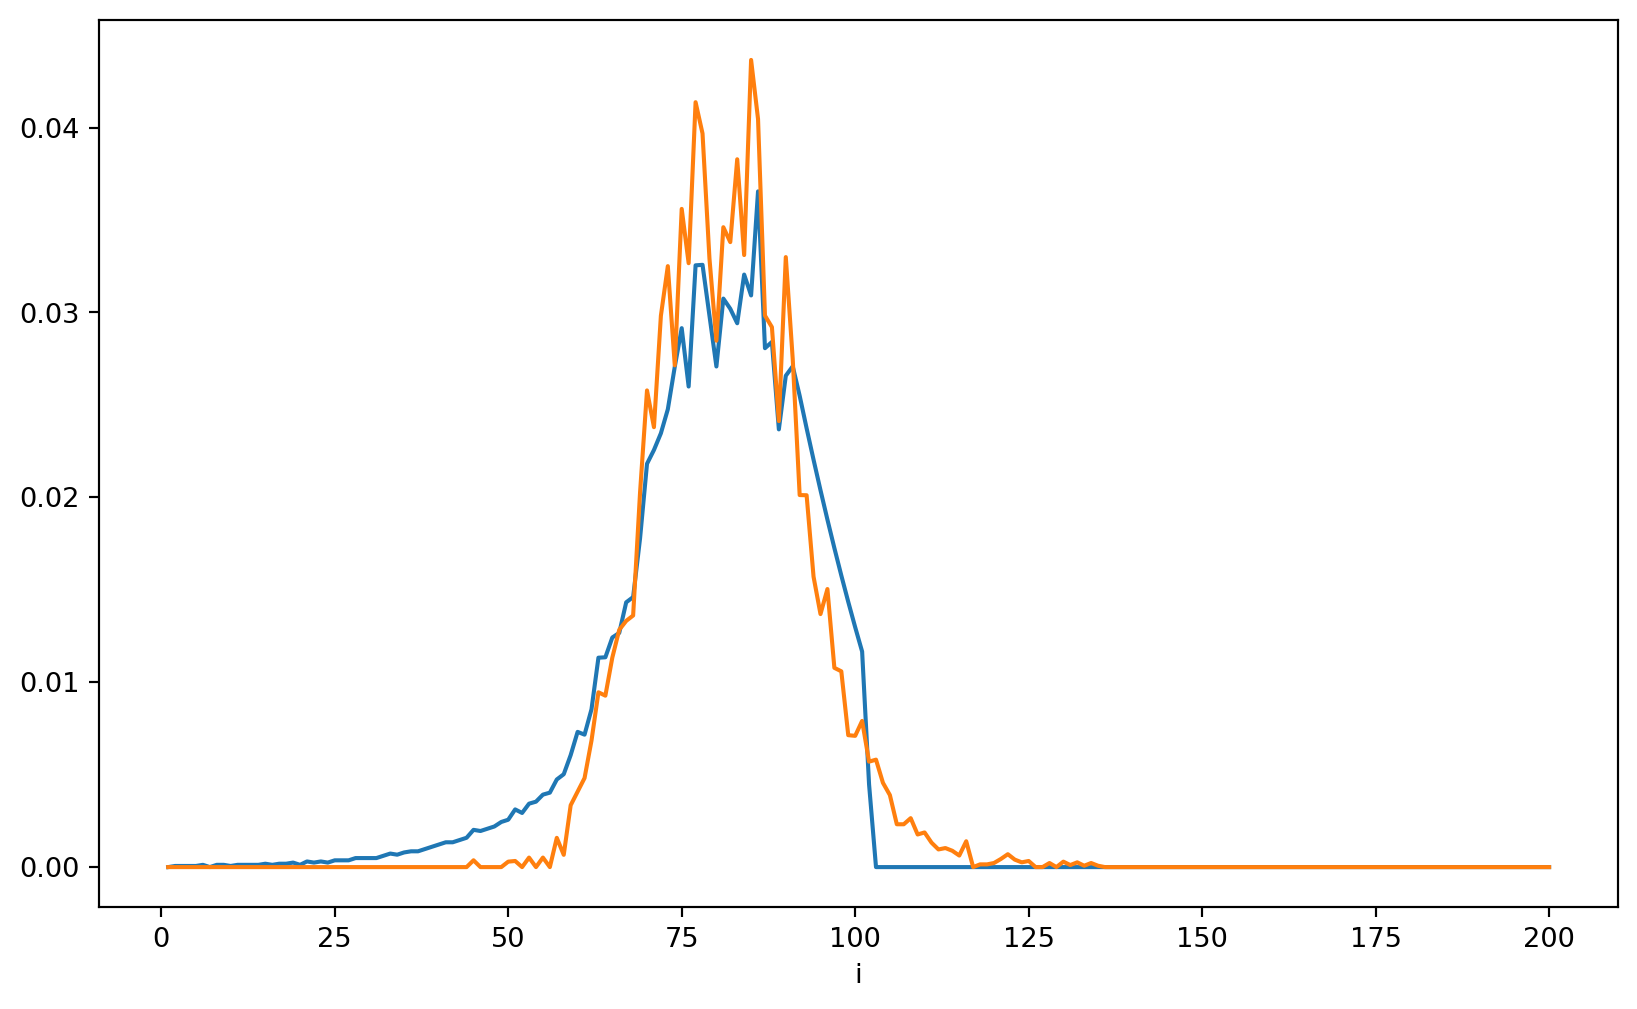

In [43]:
res3.loc[('GNB', 1992, 'national')].diff().plot()
res3.loc[('GNB', 1993, 'national')].diff().plot()

In [44]:
# ^ not good, not bad

# step 4. calculate headcount for brackets

In [45]:
def _run(ser):
    ser = ser.diff().dropna()
    ser = ser.droplevel([0, 1, 2])
    ser.index = ser.index - 1
    return ser

def step4(res3):
    gs = res3.groupby(['country', 'year', 'reporting_level'])
    return gs.apply(_run)

In [46]:
res4 = step4(res3)

In [47]:
res4

country  year  reporting_level  i  
AGO      1981  national         0      0.0
                                1      0.0
                                2      0.0
                                3      0.0
                                4      0.0
                                      ... 
ZWE      2019  national         195    0.0
                                196    0.0
                                197    0.0
                                198    0.0
                                199    0.0
Name: headcount, Length: 1336400, dtype: float64

# step5: reduce noises

Another API issue. Sometimes the value will be negative. We will check and drop them

In [48]:
res4[res4 < 0]

country  year  reporting_level  i  
ARE      2015  national         108   -1.606409e-03
         2016  national         108   -8.611784e-03
         2017  national         109   -1.545510e-02
         2018  national         110   -2.344445e-02
         2019  national         112   -2.460320e-02
                                           ...     
SVN      1993  national         97    -1.151129e-02
TTO      1983  national         140   -3.882337e-06
TUN      1986  national         143   -4.067744e-06
TUR      1983  national         144   -9.921707e-06
ZAF      2000  national         136   -1.261523e-07
Name: headcount, Length: 271, dtype: float64

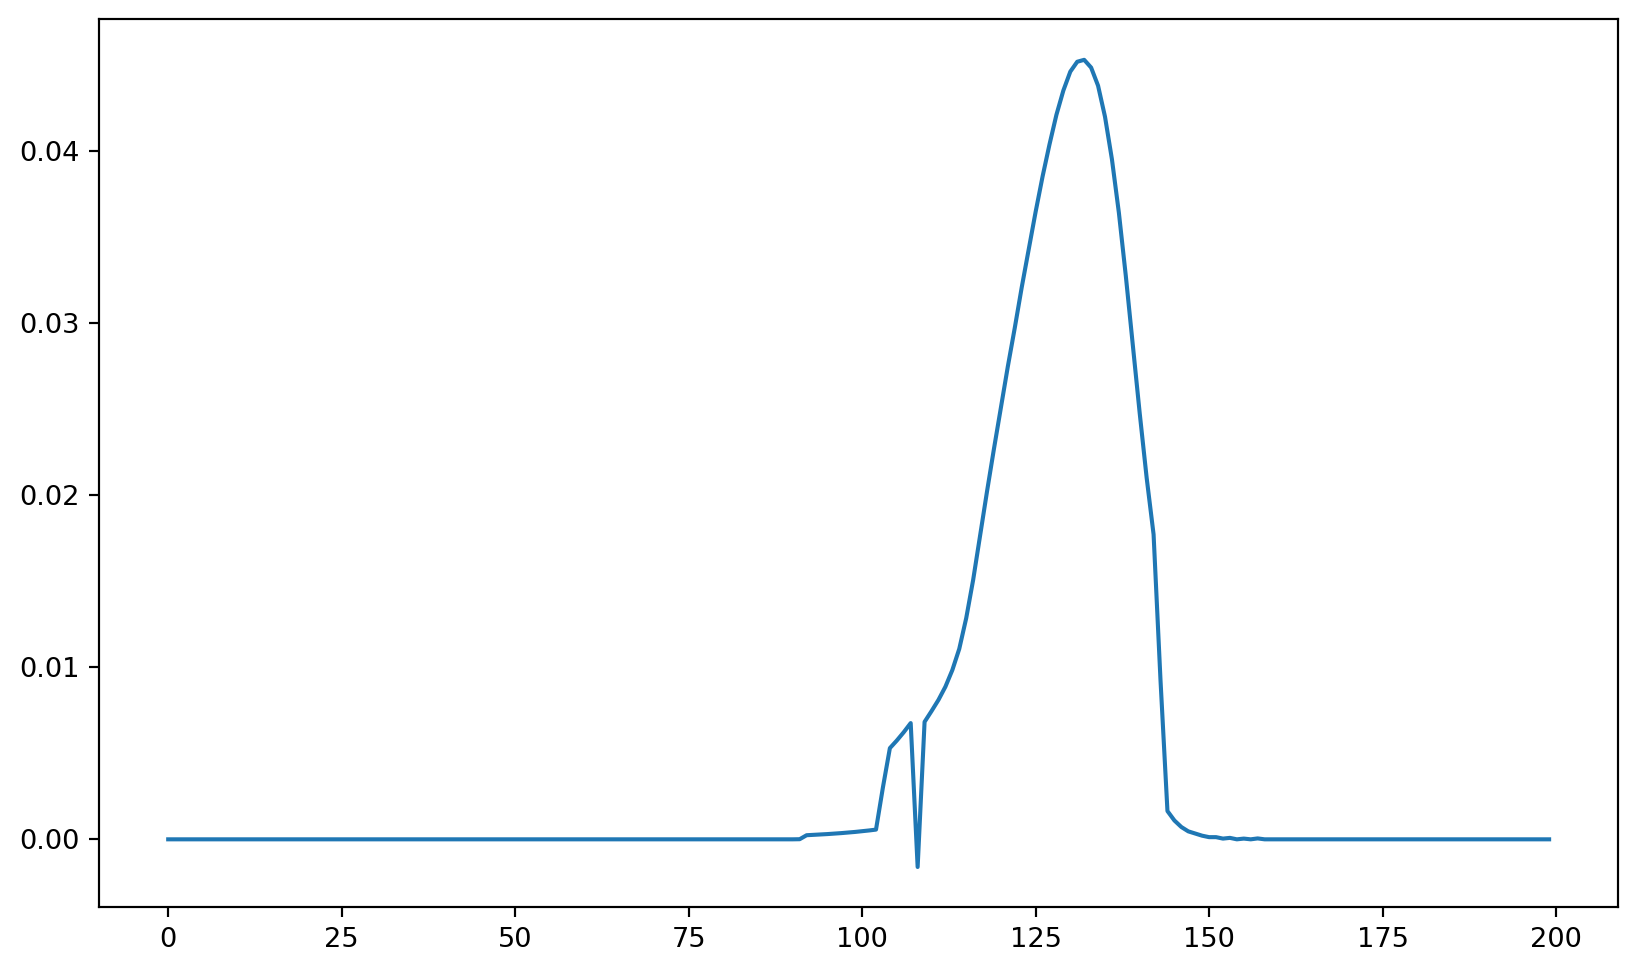

In [49]:
plt.plot(res4.loc[('ARE', 2015, 'national')])

In [50]:
# step5: reduce noises
def step5(res4):
    res5 = list()
    gs = res4.groupby(['country', 'year', 'reporting_level'])
    for g in gs.groups.keys():
        df = gs.get_group(g)
        s = df['headcount'].copy()
        todrop = set()
        if np.any(s < 0):  # if negative values exists
            where = np.where(s < 0)[0]
            for w in where:
                if w > 199:
                    print(g, w)
                if w != 199:
                    todrop.add(w+1)
                if w != 0:
                    todrop.add(w-1)
                todrop.add(w)
            s.iloc[list(todrop)] = np.nan
            res5.append(s)
        else:
            res5.append(s)
    return pd.concat(res5)

In [51]:
res4 = res4.to_frame()

In [52]:
res5 = step5(res4)

In [53]:
res5 = res5.sort_index()  # TODO: see if we can skip this step and not producing the unsorted warning

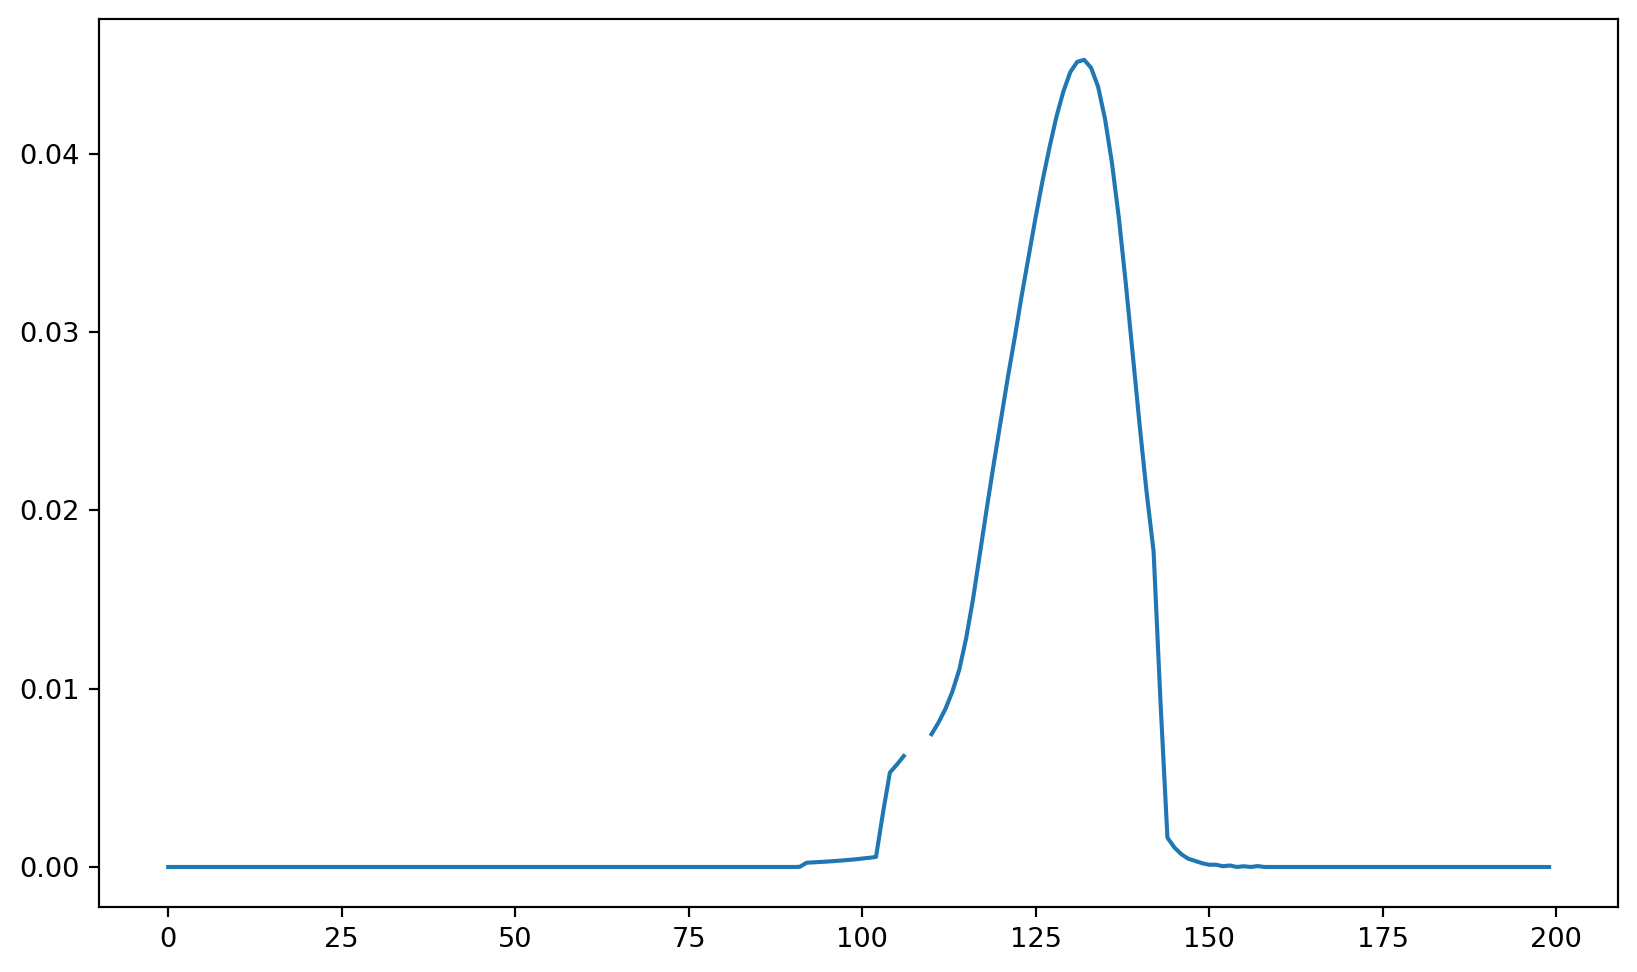

In [54]:
plt.plot(res5.loc[('ARE', 2015, 'national')])

# step6: get smoothed shape, ensure the shape sum up to 100%

TODO: add link to smoothing method doc

In [55]:
run_smooth = smoothlib.run_smooth

In [56]:
res5.index.get_level_values('country').unique()

Index(['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL',
       ...
       'UZB', 'VEN', 'VNM', 'VUT', 'WSM', 'XKX', 'YEM', 'ZAF', 'ZMB', 'ZWE'],
      dtype='object', name='country', length=169)

In [57]:
def func(x):
    """function to smooth a series"""
    run_smooth = smoothlib.run_smooth
    if x.hasnans:
        # interpolate curve if theree are nans
        x = x.interpolate()
        # if first value is nan, it won't be interpolated. we fill 0
        if pd.isnull(x.iloc[0]):
            x = x.fillna(0)
    # run smoothing, based on standard deviation
    std = x.std()
    if std < 0.010:
        res = run_smooth(x, 20, 6)
        res = run_smooth(res, 16, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 10, 1)
        res = run_smooth(res, 10, 0)
    elif std < 0.012:
        res = run_smooth(x, 20, 3)
        res = run_smooth(res, 16, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 10, 0)
        res = run_smooth(res, 8, 0)
    else:
        res = run_smooth(x, 20, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 16, 0)
        res = run_smooth(res, 10, 0)
        res = run_smooth(res, 8, 0)
    # also, make sure it will sum up to 100%
    if res.min() < 0:
        res = res - res.min()
    res = res / res.sum()
    return res

In [58]:
import warnings

In [59]:
def process_step6(ser):
    idx = ser.index
    try:
#         if ser.std() < 0.035:
#             print(idx[0])
        with warnings.catch_warnings(record=True) as w:
            s_new = func(ser)
            s_new.index = idx
            if len(w) > 0:
                print(idx[0], w[-1].category)
    except KeyboardInterrupt:
        raise
    except:
        print(idx[0])
        return pd.Series([], dtype=float)
    return s_new

In [60]:
# from multiprocessing import Pool

In [61]:
from joblib import Parallel, delayed

In [62]:
POOLSIZE = 8

def step6(res5):
    gs = res5.groupby(['country', 'year', 'reporting_level'])
    to_smooth = list()
    for g, df in gs:
        to_smooth.append(df)
    print(len(to_smooth))
    res6 = Parallel(n_jobs=POOLSIZE)(delayed(process_step6)(x) for x in to_smooth)
    return pd.concat(res6)

In [63]:
res6 = step6(res5)

6682


In [64]:
res6

country  year  reporting_level  i  
AGO      1981  national         0      7.153788e-06
                                1      8.619503e-06
                                2      1.029796e-05
                                3      1.214013e-05
                                4      1.423197e-05
                                           ...     
ZWE      2019  national         195    1.402039e-07
                                196    1.090617e-07
                                197    8.403896e-08
                                198    6.415262e-08
                                199    4.854802e-08
Length: 1336400, dtype: float64

In [65]:
# checking
res6_ = res6.reset_index()

In [66]:
counts = res6_.groupby(['country', 'year', 'reporting_level']).count()['i']
counts[counts != 200]

Series([], Name: i, dtype: int64)

0.01113721075405791


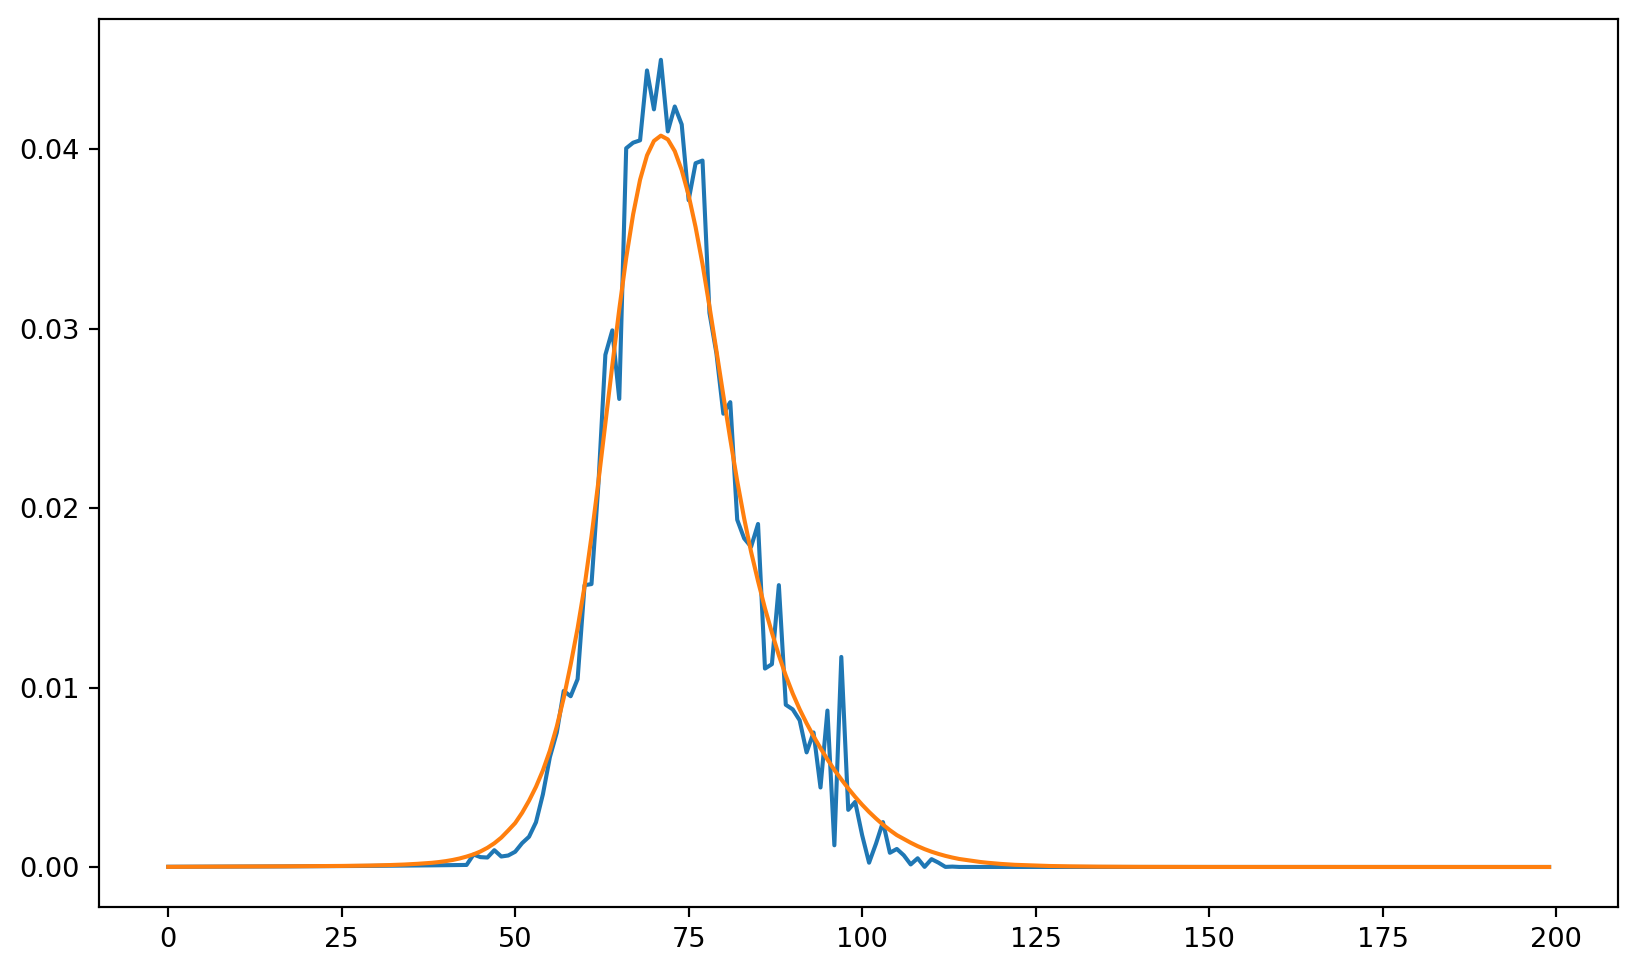

In [67]:
# check those interpolated

# sns.reset_defaults()

i = ('SLE', 2003, 'national')

print(res5.loc[i].std())
plt.plot(res5.loc[i])
plt.plot(res6.loc[i])

In [64]:
# since the smoothed shapes look good for these datapoints, I think we can safely ignore these warnings.

In [65]:
# import pickle
# pickle.dump(res6, open('./res6.pickle', 'wb'))

In [66]:
# import pickle
# res6 = pickle.load(open('./res6.pickle', 'rb'))

# step6: renaming and make it DDF valid
also change xkx to kos for country, to align with open-numbers namespace. xkx/kos is the only difference between wb country entities and open-numbers country entities

In [68]:
def step7(res6):
    res7 = res6.copy()
    res7.name = 'population_percentage'
    res7.index.names = ['country', 'year', 'reporting_level', 'bracket']
    # also change the reporting_level to synonyms, to save space.
    res7 = res7.reset_index()
    res7['reporting_level'] = res7['reporting_level'].replace({'national': 'n', 'urban': 'u', 'rural': 'r'})
    res7['country'] = res7['country'].map(str.lower)
    res7['country'] = res7['country'].replace({'xkx': 'kos'})
    res7['reporting_level'] = res7['reporting_level'].map(str.lower)
    return res7.set_index(['country', 'year', 'reporting_level'])

In [69]:
res7 = step7(res6)

In [70]:
res7

bracket  population_percentage
country year reporting_level                                
ago     1981 n                      0           7.153788e-06
             n                      1           8.619503e-06
             n                      2           1.029796e-05
             n                      3           1.214013e-05
             n                      4           1.423197e-05
...                               ...                    ...
zwe     2019 n                    195           1.402039e-07
             n                    196           1.090617e-07
             n                    197           8.403896e-08
             n                    198           6.415262e-08
             n                    199           4.854802e-08

[1336400 rows x 2 columns]

In [71]:
# double check if all series have 200 brackets
res7.groupby(['country', 'year', 'reporting_level']).count()['bracket'].unique()

array([200])

In [72]:
# create a list of all avaliable povcal shapes, which is required in neighbours calculation
povcal_country_year = res7.reset_index()[['country', 'year']].drop_duplicates()

In [151]:
povcal_country_year.to_csv('../source/fixtures/povcal_country_year.csv', index=False)

In [152]:
# res7.to_csv('../precomputed/current/res7.csv')

# step7: change bracket numbers

when we merge shapes, we want to align the shapes by mean income

so we should change bracket numbers so that the mean income bracket is 0

income data comes from fasttrack

In [76]:
# income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mhhinc--by--country--time.csv'

In [77]:
def step8(df):
    income = pd.read_csv(income_file).set_index(['country', 'time'])
    income.index.names = ['country', 'year']
    income.columns = ['income']

    res = list()
    gs = df.groupby(['country', 'year', 'reporting_level'])
    for g, gdf in gs:
        df_ = gdf.copy()
        g_ = (g[0], g[1])
        try:
            m = income.loc[g_, 'income']
        except KeyError:
            print(f"missing: {g_}")
            continue
        b = etllib.bracket_number_from_income(m)  # 200 brackets
        # b = bracket_number_from_income(m)
        df_['bracket'] = df_['bracket'] - b
        res.append(df_)

    return pd.concat(res)

In [78]:
res8 = step8(res7)

missing: ('kos', 2000)
missing: ('kos', 2001)
missing: ('kos', 2002)
missing: ('kos', 2003)
missing: ('kos', 2004)
missing: ('kos', 2005)
missing: ('kos', 2006)
missing: ('kos', 2007)
missing: ('kos', 2008)
missing: ('kos', 2009)
missing: ('kos', 2010)
missing: ('kos', 2011)
missing: ('kos', 2012)
missing: ('kos', 2013)
missing: ('kos', 2014)
missing: ('kos', 2015)
missing: ('kos', 2016)
missing: ('kos', 2017)
missing: ('kos', 2018)
missing: ('kos', 2019)
missing: ('mhl', 1981)
missing: ('mhl', 1982)
missing: ('mhl', 1983)
missing: ('mhl', 1984)
missing: ('mhl', 1985)
missing: ('mhl', 1986)
missing: ('mhl', 1987)
missing: ('mhl', 1988)
missing: ('mhl', 1989)
missing: ('mhl', 1990)
missing: ('mhl', 1991)
missing: ('mhl', 1992)
missing: ('mhl', 1993)
missing: ('mhl', 1994)
missing: ('mhl', 1995)
missing: ('mhl', 1996)
missing: ('mhl', 1997)
missing: ('mhl', 1998)
missing: ('mhl', 1999)
missing: ('mhl', 2000)
missing: ('mhl', 2001)
missing: ('mhl', 2002)
missing: ('mhl', 2003)
missing: ('

In [79]:
res8 

bracket  population_percentage
country year reporting_level                                
ago     1981 n                   -170           7.153788e-06
             n                   -169           8.619503e-06
             n                   -168           1.029796e-05
             n                   -167           1.214013e-05
             n                   -166           1.423197e-05
...                               ...                    ...
zwe     2019 n                     13           1.402039e-07
             n                     14           1.090617e-07
             n                     15           8.403896e-08
             n                     16           6.415262e-08
             n                     17           4.854802e-08

[1313600 rows x 2 columns]

In [157]:
# res8.to_csv('../precomputed/current/res8.csv')

# step 8: mixing shapes

we pre-computed neighbours, check the other notebook for process to compute neighbours

- 8.1 create estimate shapes
- 8.2 create shapes for povcal period
- 8.3 merge all results

In [ ]:
assert 0, "please check if we should update neighbours_list.json, then continue"

In [80]:
import json
from functools import partial

In [81]:
fp = open('../source/fixtures/neighbours_list.json', 'r')
jsonstring = fp.read()

In [82]:
all_neighbours_json = json.loads(jsonstring)

In [83]:
# income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
# gini_file =  '../../../ddf--gapminder--fasttrack/ddf--datapoints--gini--by--country--time.csv'
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mhhinc--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--fasttrack/ddf--datapoints--gini_2100--by--country--time.csv'

income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['country', 'time'])

income.index.names = ['country', 'year']
gini.index.names = ['country', 'year']

income.columns = ['income']
gini.columns = ['gini']

In [84]:
income_gini = pd.concat([income, gini], axis=1)
income_gini = income_gini.dropna(how='any').sort_index()

In [85]:
known_shapes = res8.copy()
shapes_noc = known_shapes.set_index(['bracket'], append=True)

In [86]:
shapes_noc

population_percentage
country year reporting_level bracket                       
ago     1981 n               -170              7.153788e-06
                             -169              8.619503e-06
                             -168              1.029796e-05
                             -167              1.214013e-05
                             -166              1.423197e-05
...                                                     ...
zwe     2019 n                13               1.402039e-07
                              14               1.090617e-07
                              15               8.403896e-08
                              16               6.415262e-08
                              17               4.854802e-08

[1313600 rows x 1 columns]

In [91]:
def applyfunc(ser):
    ct = ser.index.get_level_values('reporting_level')
    for c in 'naur':
        if c in ct:
            return ser[ct == c]['population_percentage']

In [92]:
shapes_noc2 = shapes_noc.groupby(['country', 'year'], as_index=False).apply(applyfunc)
shapes_noc2 = shapes_noc2.reset_index(level=0, drop=True).sort_index()

In [93]:
shapes_noc2 = shapes_noc2.reset_index('reporting_level', drop=True)

In [94]:
shapes_noc2

country  year  bracket
ago      1981  -170       7.153788e-06
               -169       8.619503e-06
               -168       1.029796e-05
               -167       1.214013e-05
               -166       1.423197e-05
                              ...     
zwe      2019   13        1.402039e-07
                14        1.090617e-07
                15        8.403896e-08
                16        6.415262e-08
                17        4.854802e-08
Name: population_percentage, Length: 1266800, dtype: float64

In [95]:
shapes_noc2.loc['kaz']

year  bracket
1981  -193       0.0
      -192       0.0
      -191       0.0
      -190       0.0
      -189       0.0
                ... 
2019   5         0.0
       6         0.0
       7         0.0
       8         0.0
       9         0.0
Name: population_percentage, Length: 7800, dtype: float64

In [170]:
# shapes_noc2.to_csv('../precomputed/current/shapes_no_coverage_type.csv')

In [96]:
import constants

In [97]:
def shape_to_mountain(shape, income):
    bracket = etllib.bracket_number_from_income(income, integer=False)
    shape.index = shape.index + bracket
    # if 0 in shape.index.values:
    #     res = shape.loc[0:199]
    # else:
    #     res = shape.loc[:199]
    # if len(res) != 200:
        # print(f'not enough points in mixed shape: {idx}')
        # new_idx = pd.Index(range(200))
        # res = shape.reindex(new_idx, fill_value=0)
    res = shape.copy()
    return res


def get_estimated_mountain(idx, income, known_shapes, all_country_year, neighbours, n=50):
    country, year = idx
    wpov, was = constants.all_weights[year]

    first_known_shape = shapeslib.get_nearest_known_shape(country, year, known_shapes)
    if first_known_shape is None:
        print(idx, ": no first known shape")
        return None

    if wpov == 1:
        mixed_shape = first_known_shape
    elif wpov == 0:
        mixed_shape = get_average_shape2(country, year, known_shapes, all_country_year, neighbours)
    else:
        average_shape = get_average_shape2(country, year, known_shapes, all_country_year, neighbours)
        mixed_shape = shapeslib.merge_nshapes_with_weights([first_known_shape, average_shape], (wpov, was))

    return shape_to_mountain(mixed_shape, income)


In [98]:
# get_estimated_mountain = shapeslib.get_estimated_mountain
# shape_to_mountain = shapeslib.shape_to_mountain
get_average_shape2 = shapeslib.get_average_shape2
get_income_gini = shapeslib.get_income_gini

# bracket_number_from_income = etllib.bracket_number_from_income

In [99]:
unknown_list = list()

all_countries = income_gini.index.get_level_values(0).unique()
known_countries = shapes_noc.index.get_level_values(0).unique()

for country in all_countries:
    if country not in known_countries:
        unknown_list.append(country)
        print(f'{country} not available in povcal')

afg not available in povcal
atg not available in povcal
bhr not available in povcal
bhs not available in povcal
brb not available in povcal
brn not available in povcal
cub not available in povcal
dma not available in povcal
eri not available in povcal
gnq not available in povcal
grd not available in povcal
hkg not available in povcal
khm not available in povcal
kna not available in povcal
kwt not available in povcal
lby not available in povcal
nzl not available in povcal
omn not available in povcal
plw not available in povcal
prk not available in povcal
qat not available in povcal
sau not available in povcal
sgp not available in povcal
vct not available in povcal


In [100]:
known_list = known_shapes.index.droplevel('reporting_level').values.tolist()

('FRA', 1995, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('CHE', 1993, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('AUS', 2004, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('ISR', 1992, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('AUS', 2009, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('CHN', 2005, 'urban', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('RUS', 2015, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('NOR', 1996, 'national', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>


In [101]:
all_country_year = list(zip(shapes_noc2.index.get_level_values(0), shapes_noc2.index.get_level_values(1)))
all_country_year = pd.Series(all_country_year, index=shapes_noc2.index)

In [102]:
def fix_column_names(k, df):
    country, year = k
    # print(country, year)
    # assert isinstance(df, pd.Series)
    df.index.name = 'bracket'
    df.name = 'income_mountain'
    df = df.reset_index()
    df['country'] = country
    df['year'] = year
    df = df.set_index(['country', 'year', 'bracket'])
    return df

In [103]:
def process_step8(i, skip_list, shape_known_list):
    country, year = i
    if country in unknown_list: 
        # only use Average Shapes
        income, _ = get_income_gini(i, income_gini)
        average_shape = get_average_shape2(country, year, shapes_noc2, all_country_year, all_neighbours_json)
        res = shape_to_mountain(average_shape, income)
        return fix_column_names(i, res)
    if i not in shape_known_list:
        income, _ = get_income_gini(i, income_gini)
        res = get_estimated_mountain(i, income, shapes_noc2, all_country_year, all_neighbours_json)
        # res = shapeslib.get_estimated_mountain(i, shapes, income_gini, resample=False) 
        return fix_column_names(i, res)

In [158]:
# check all year's weights
constants.all_weights

{1800: (0, 1),
 1801: (0, 1),
 1802: (0, 1),
 1803: (0, 1),
 1804: (0, 1),
 1805: (0, 1),
 1806: (0, 1),
 1807: (0, 1),
 1808: (0, 1),
 1809: (0, 1),
 1810: (0, 1),
 1811: (0, 1),
 1812: (0, 1),
 1813: (0, 1),
 1814: (0, 1),
 1815: (0, 1),
 1816: (0, 1),
 1817: (0, 1),
 1818: (0, 1),
 1819: (0, 1),
 1820: (0, 1),
 1821: (0, 1),
 1822: (0, 1),
 1823: (0, 1),
 1824: (0, 1),
 1825: (0, 1),
 1826: (0, 1),
 1827: (0, 1),
 1828: (0, 1),
 1829: (0, 1),
 1830: (0, 1),
 1831: (0, 1),
 1832: (0, 1),
 1833: (0, 1),
 1834: (0, 1),
 1835: (0, 1),
 1836: (0, 1),
 1837: (0, 1),
 1838: (0, 1),
 1839: (0, 1),
 1840: (0, 1),
 1841: (0, 1),
 1842: (0, 1),
 1843: (0, 1),
 1844: (0, 1),
 1845: (0, 1),
 1846: (0, 1),
 1847: (0, 1),
 1848: (0, 1),
 1849: (0, 1),
 1850: (0, 1),
 1851: (0, 1),
 1852: (0, 1),
 1853: (0, 1),
 1854: (0, 1),
 1855: (0, 1),
 1856: (0, 1),
 1857: (0, 1),
 1858: (0, 1),
 1859: (0, 1),
 1860: (0, 1),
 1861: (0, 1),
 1862: (0, 1),
 1863: (0, 1),
 1864: (0, 1),
 1865: (0, 1),
 1866: (0,

In [104]:
run = partial(process_step8, skip_list=unknown_list, shape_known_list=known_list)

In [105]:
from multiprocessing import Pool

In [159]:
POOLSIZE = 8
with Pool(POOLSIZE) as p:
    estimated = p.map(run, income_gini.index.values)

In [160]:
estimated = pd.concat(estimated)

In [161]:
estimated

income_mountain
country year bracket                   
afg     1800 3.32890       1.781790e-06
             4.32890       3.589771e-06
             5.32890       5.772364e-06
             6.32890       7.524931e-06
             7.32890       7.194574e-05
...                                 ...
zwe     2100 253.33545     5.822443e-11
             254.33545     3.011651e-13
             255.33545     0.000000e+00
             256.33545     0.000000e+00
             257.33545     0.000000e+00

[11354041 rows x 1 columns]

In [111]:
# estimated.to_csv('../precomputed/current/estimated_mountain_200.csv')

In [184]:
# to 50 brackets

In [113]:
import seaborn as sns

In [114]:
# reindex and resampling
def resample_to_int(ser):
    # ser = ser.droplevel([0, 1])
    new_idx = pd.RangeIndex.from_range(range(200))
    res = ser.reindex(ser.index.union(new_idx))
    res = res.interpolate(method='slinear')
    return res.reindex(new_idx).fillna(0)

In [115]:
def resample_to_50(ser):
    res = pd.Series([x.sum() for x in np.split(ser.values, 50)])
    res.index.name = 'bracket'
    return res

In [162]:
r = estimated.loc['swe', 2040, :].copy()

In [163]:
r2 = resample_to_50(resample_to_int(r))

In [164]:
r2.sum()

0.9999301780718293

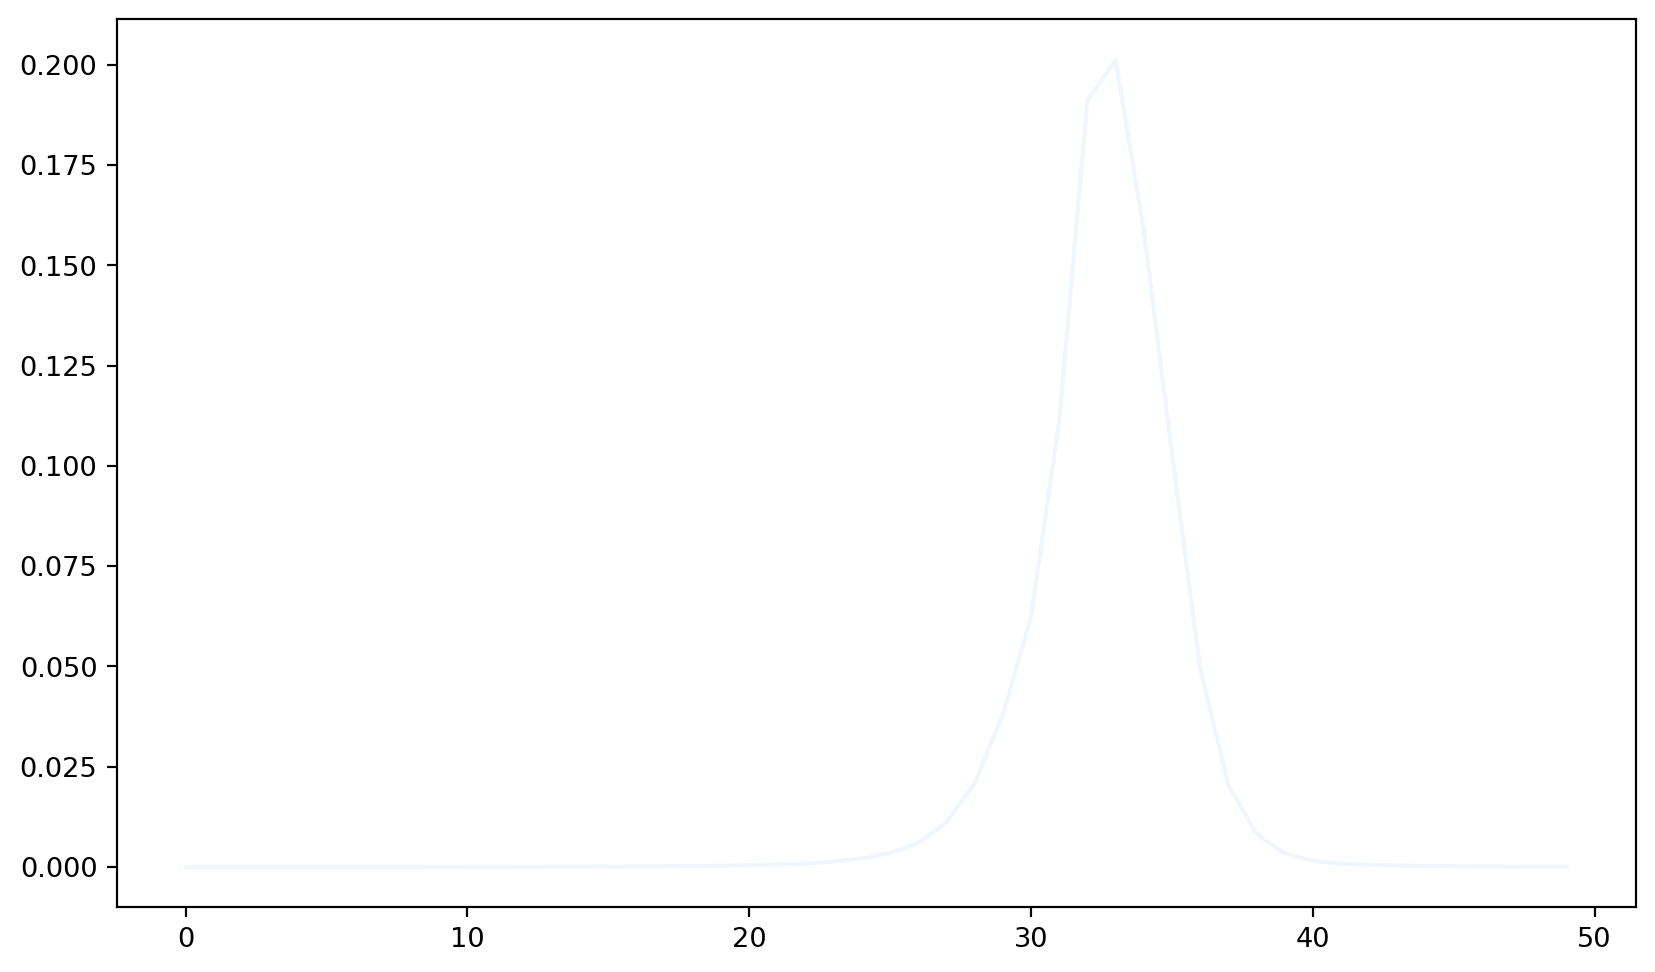

In [165]:
# plt.plot(r)
plt.plot(r2) 
# r['income_mountain'].plot()

In [166]:
def run_resample_to_int(x):
    ser_copy = x.droplevel([0, 1])
    # ser_copy = x.copy()
    # print(ser_copy.head())
    return resample_to_int(ser_copy)

est = estimated.groupby(['country', 'year'])['income_mountain'].apply(run_resample_to_int)

In [167]:
est

country  year     
afg      1800  0      0.000000
               1      0.000000
               2      0.000000
               3      0.000000
               4      0.000003
                        ...   
zwe      2100  195    0.000015
               196    0.000013
               197    0.000012
               198    0.000010
               199    0.000009
Name: income_mountain, Length: 10111000, dtype: float64

In [168]:
est.index.names = ['country', 'year', 'bracket']

In [169]:
est[est<0]  # check if there are abnormal numbers

Series([], Name: income_mountain, dtype: float64)

In [134]:
res7 # povcal period data

bracket  population_percentage
country year reporting_level                                
ago     1981 n                      0           7.153788e-06
             n                      1           8.619503e-06
             n                      2           1.029796e-05
             n                      3           1.214013e-05
             n                      4           1.423197e-05
...                               ...                    ...
zwe     2019 n                    195           1.402039e-07
             n                    196           1.090617e-07
             n                    197           8.403896e-08
             n                    198           6.415262e-08
             n                    199           4.854802e-08

[1336400 rows x 2 columns]

In [170]:
povcal = []

for c in res7.index.get_level_values('country').unique():
    df = res7.loc[[c]]
    ct_idx = df.index.get_level_values('reporting_level')
    for ct in 'naur':
        if ct in ct_idx:
            df_ = df[ct_idx == ct].copy()
            df_ = df_.reset_index('reporting_level', drop=True)
            povcal.append(df_)
            break

In [171]:
povcal[0].loc[('ago', 1981)].sum()

bracket                  19900.0
population_percentage        1.0
dtype: float64

In [172]:
povcal = pd.concat(povcal).set_index('bracket', append=True)

In [173]:
povcal.columns = ['income_mountain']

In [174]:
povcal

income_mountain
country year bracket                 
ago     1981 0           7.153788e-06
             1           8.619503e-06
             2           1.029796e-05
             3           1.214013e-05
             4           1.423197e-05
...                               ...
zwe     2019 195         1.402039e-07
             196         1.090617e-07
             197         8.403896e-08
             198         6.415262e-08
             199         4.854802e-08

[1289600 rows x 1 columns]

In [175]:
est

country  year  bracket
afg      1800  0          0.000000
               1          0.000000
               2          0.000000
               3          0.000000
               4          0.000003
                            ...   
zwe      2100  195        0.000015
               196        0.000013
               197        0.000012
               198        0.000010
               199        0.000009
Name: income_mountain, Length: 10111000, dtype: float64

In [176]:
povcal_and_est = pd.concat([est.to_frame(), povcal])

In [177]:
povcal_and_est  # this is the 200 bracket version

income_mountain
country year bracket                 
afg     1800 0           0.000000e+00
             1           0.000000e+00
             2           0.000000e+00
             3           0.000000e+00
             4           2.995126e-06
...                               ...
zwe     2019 195         1.402039e-07
             196         1.090617e-07
             197         8.403896e-08
             198         6.415262e-08
             199         4.854802e-08

[11400600 rows x 1 columns]

In [178]:
res9 = povcal_and_est.groupby(['country', 'year'])['income_mountain'].apply(resample_to_50)

In [179]:
res9 = res9.sort_index().to_frame()

In [180]:
res9 

income_mountain
country year bracket                 
afg     1800 0               0.000000
             1               0.000066
             2               0.000531
             3               0.000899
             4               0.001353
...                               ...
zwe     2100 45              0.000237
             46              0.000162
             47              0.000108
             48              0.000070
             49              0.000045

[2850150 rows x 1 columns]

In [181]:
res9.index.names = ['geo', 'time', 'income_bracket_50']
res9.columns = ['population_percentage']

In [182]:
res9.to_csv('../datapoints/ddf--datapoints--population_percentage--by--geo--time--income_bracket_50.csv')

In [183]:
import pickle
pickle.dump(povcal_and_est, open('../datapoints/headcount_200_bracket.pkl', 'wb'))

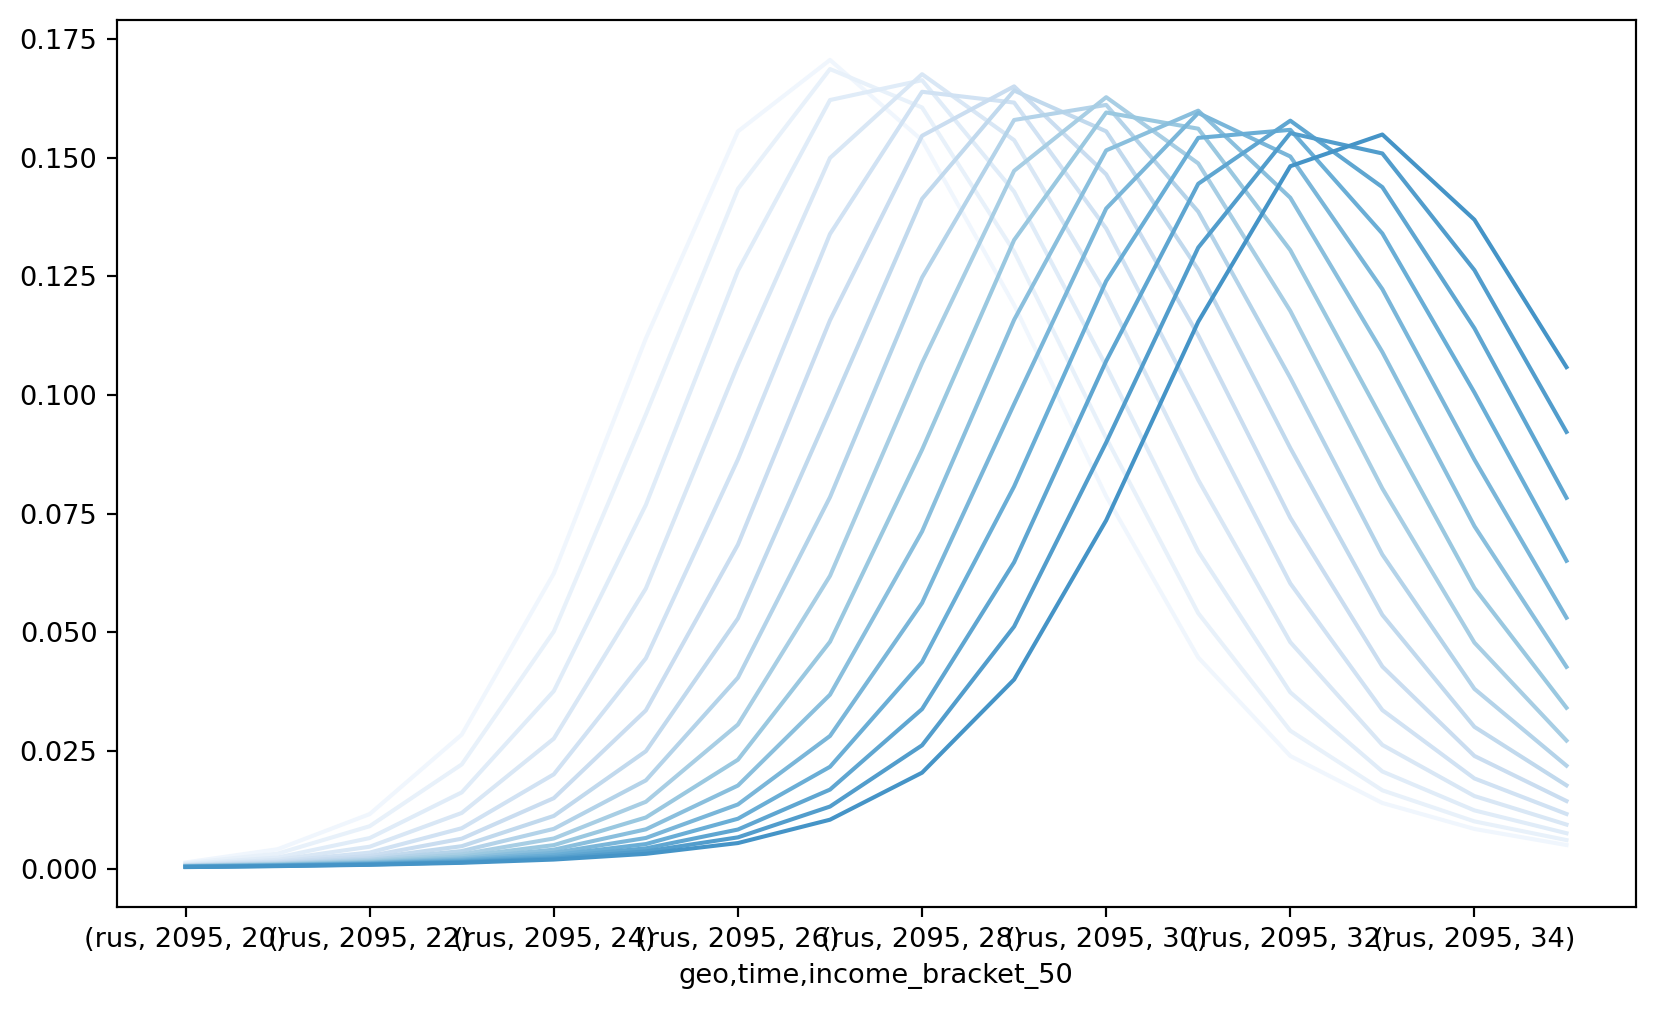

In [184]:
sns.set_palette('Blues', 25)

for i in range(2020, 2100, 5):
    # resample_to_int_kde_2(est.loc['swe', i, :]).plot()
    res9.loc['rus', i, 20:35]['population_percentage'].plot()
    # plt.plot(a.bracket, a.income_mountain)

# step 9. change table format

In [185]:
res10 = res9.copy()
res10.index.names = ['geo', 'time', 'bracket']

In [186]:
res10 

population_percentage
geo time bracket                       
afg 1800 0                     0.000000
         1                     0.000066
         2                     0.000531
         3                     0.000899
         4                     0.001353
...                                 ...
zwe 2100 45                    0.000237
         46                    0.000162
         47                    0.000108
         48                    0.000070
         49                    0.000045

[2850150 rows x 1 columns]

In [187]:
res10.stack().loc[('ago', 1981)].sum()

1.0

# step 10. calculate population count

In [188]:
pop_file = '../../../ddf--gapminder--systema_globalis/countries-etc-datapoints/ddf--datapoints--population_total--by--geo--time.csv'
pop = pd.read_csv(pop_file).set_index(['geo', 'time'])['population_total']

In [189]:
res11 = []
gs = res10.groupby(['geo', 'time'])
for g, df in gs:
    try:
        p = pop.loc[g]
    except KeyError:
        print('no population for: ', g)
        res11.append(None)
        continue
    row_pop = np.round(df * p)
    # row_pop_str = ', '.join(row_pop.astype(int).astype(str))
    res11.append(row_pop)

no population for:  ('kos', 2000)
no population for:  ('kos', 2001)
no population for:  ('kos', 2002)
no population for:  ('kos', 2003)
no population for:  ('kos', 2004)
no population for:  ('kos', 2005)
no population for:  ('kos', 2006)
no population for:  ('kos', 2007)
no population for:  ('kos', 2008)
no population for:  ('kos', 2009)
no population for:  ('kos', 2010)
no population for:  ('kos', 2011)
no population for:  ('kos', 2012)
no population for:  ('kos', 2013)
no population for:  ('kos', 2014)
no population for:  ('kos', 2015)
no population for:  ('kos', 2016)
no population for:  ('kos', 2017)
no population for:  ('kos', 2018)
no population for:  ('kos', 2019)


In [190]:
res11 = pd.concat(res11)

In [191]:
res11 

population_percentage
geo time bracket                       
afg 1800 0                          0.0
         1                        216.0
         2                       1741.0
         3                       2948.0
         4                       4439.0
...                                 ...
zwe 2100 45                      7340.0
         46                      5010.0
         47                      3337.0
         48                      2179.0
         49                      1388.0

[2849150 rows x 1 columns]

In [192]:
res11 = res11.dropna()

In [193]:
res11.columns = ['population']

In [194]:
res11['population'] = res11['population'].astype(int)

In [195]:
res11.to_csv('../datapoints/ddf--datapoints--population--by--geo--time--income_bracket_50.csv')

In [196]:
res12 = res11.unstack().copy()

In [197]:
res12

population                                                          \
bracket          0    1     2     3     4     5     6      7      8      9    
geo time                                                                      
afg 1800          0  216  1741  2948  4439  6241  8676  12209  17621  26272   
    1801          0   66  1532  2724  4181  5913  8215  11525  16550  24532   
    1802          0   44  1230  2519  3933  5604  7791  10907  15589  22985   
    1803          0   27   942  2321  3689  5306  7385  10314  14676  21524   
    1804          0   19   676  2134  3448  5019  7001   9753  13825  20169   
...             ...  ...   ...   ...   ...   ...   ...    ...    ...    ...   
zwe 2096          0    0     0     0     0     0     0      0      0      0   
    2097          0    0     0     0     0     0     0      0      0      0   
    2098          0    0     0     0     0     0     0      0      0      0   
    2099          0    0     0     0     0     0     0      0      0      0   
    2100          0    0     0     0     0     0     0      0      0      0   

          ...                                                                   
bracket   ...     40     41     42     43     44    45    46    47    48    49  
geo time  ...                                                                   
afg 1800  ...     48     28     16      9      5     2     1     1     0     0  
    1801  ...     52     30     17     10      5     3     1     1     0     0  
    1802  ...     57     33     19     11      6     3     2     1     0     0  
    1803  ...     61     36     21     12      6     3     2     1     0     0  
    1804  ...     67     39     23     13      7     4     2     1     0     0  
...       ...    ...    ...    ...    ...    ...   ...   ...   ...   ...   ...  
zwe 2096  ...  43913  29269  19832  13664   9405  6427  4362  2884  1869  1179  
    2097  ...  45514  30287  20523  14116   9721  6648  4521  2995  1944  1229  
    2098  ...  47122  31308  21216  14569  10037  6869  4680  3105  2020  1280  
    2099  ...  48751  32341  21916  15027  10357  7093  4841  3217  2096  1331  
    2100  ...  50550  33473  22681  15523  10703  7340  5010  3337  2179  1388  

[56983 rows x 50 columns]

In [198]:
def row_to_str(row):
    row_str = ', '.join(row['population'].astype(int).astype(str))
    return row_str

res12 = res11.groupby(['geo', 'time']).apply(row_to_str)

In [199]:
res12 

geo  time
afg  1800    0, 216, 1741, 2948, 4439, 6241, 8676, 12209, 1...
     1801    0, 66, 1532, 2724, 4181, 5913, 8215, 11525, 16...
     1802    0, 44, 1230, 2519, 3933, 5604, 7791, 10907, 15...
     1803    0, 27, 942, 2321, 3689, 5306, 7385, 10314, 146...
     1804    0, 19, 676, 2134, 3448, 5019, 7001, 9753, 1382...
                                   ...                        
zwe  2096    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 27, 1012, ...
     2097    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 20, 758, 6...
     2098    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 13, 497, 6...
     2099    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 252, 58...
     2100    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 223, 53...
Length: 56983, dtype: object

In [200]:
res12.name = 'income_mountain_50bracket_shape_for_log'

In [201]:
res12.index.names = ['country', 'time']

In [202]:
res12.to_csv('../../income_mountain/ddf--datapoints--income_mountain_50bracket_shape_for_log--by--country--time.csv')